# First, let's load the MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import requests # for alpha-binary digits

# import torch
# from torchvision import datasets, transforms # for MNIST

ModuleNotFoundError: No module named 'torch'

### Downloading, preprocessing & loading MNIST

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST('../data/processed', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# Download and load the test data
testset = datasets.MNIST('../data/processed', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [ ]:
dataiter = iter(trainloader)

In [ ]:
images, labels = dataiter.next()

In [ ]:
print(images.shape, labels.shape) #loading 64 images of shape 28x28

torch.Size([64, 1, 28, 28]) torch.Size([64])


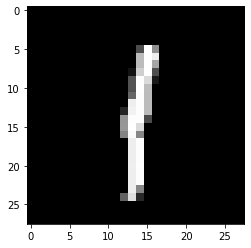

In [ ]:
plt.imshow(images[0].squeeze(), cmap='Greys_r')

---

### Downloading AlphaBinary

In [7]:
# alpha_binary_mat = requests.get('https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat')

In [8]:
# with open('../data/raw/alpha_binary.mat', 'wb') as f:
    # f.write(alpha_binary_mat.content)

### Preprocessing AlphaBinary

In [2]:
import scipy.io

In [3]:
file_mat = '../data/raw/alpha_binary.mat'
mat = scipy.io.loadmat(file_mat)

In [4]:
type(mat)

dict

In [5]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'dat', 'numclass', 'classlabels', 'classcounts'])

In [6]:
mat['dat'].shape # 39 samples for each of the 36 classes - 10 digits & 26 letters

(36, 39)

In [7]:
mat['classlabels'][0]

array([array(['0'], dtype='<U1'), array(['1'], dtype='<U1'),
       array(['2'], dtype='<U1'), array(['3'], dtype='<U1'),
       array(['4'], dtype='<U1'), array(['5'], dtype='<U1'),
       array(['6'], dtype='<U1'), array(['7'], dtype='<U1'),
       array(['8'], dtype='<U1'), array(['9'], dtype='<U1'),
       array(['A'], dtype='<U1'), array(['B'], dtype='<U1'),
       array(['C'], dtype='<U1'), array(['D'], dtype='<U1'),
       array(['E'], dtype='<U1'), array(['F'], dtype='<U1'),
       array(['G'], dtype='<U1'), array(['H'], dtype='<U1'),
       array(['I'], dtype='<U1'), array(['J'], dtype='<U1'),
       array(['K'], dtype='<U1'), array(['L'], dtype='<U1'),
       array(['M'], dtype='<U1'), array(['N'], dtype='<U1'),
       array(['O'], dtype='<U1'), array(['P'], dtype='<U1'),
       array(['Q'], dtype='<U1'), array(['R'], dtype='<U1'),
       array(['S'], dtype='<U1'), array(['T'], dtype='<U1'),
       array(['U'], dtype='<U1'), array(['V'], dtype='<U1'),
       array(['W'], dtyp

In [8]:
labels = np.array([label.item() for label in mat['classlabels'][0]])

In [9]:
labels

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype='<U1')

---

In [10]:
images = mat['dat']

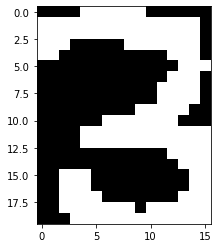

In [11]:
plt.imshow(images[3][0], cmap='Greys_r')

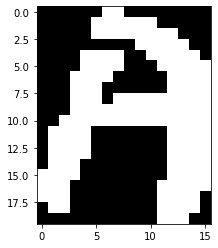

In [12]:
plt.imshow(images[10][0], cmap='Greys_r')

In [13]:
labels_array = []

In [14]:
for index, classe in enumerate(images):
    for image in classe:
        labels_array.append(labels[index])

labels_array = np.array(labels_array)

In [15]:
labels_array.shape[0] == 36*39

True

In [16]:
labels_array[0], labels_array[38], labels_array[39]

('0', '0', '1')

---

In [17]:
images[0][0].flatten().shape

(320,)

In [18]:
images[10][0].shape

(20, 16)

In [19]:
images[0, 1].shape

(20, 16)

In [20]:
def lire_alpha_digit(all_images, classes:list):
    data = []
    for cls in classes:
        for image in all_images[cls]:
            data.append(image.flatten().reshape(-1,1))
    
    return np.array(data)

All our data has been loaded and is ready to be used in a python data environment !

---

# Creating NN classes & methods

In [21]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [22]:
def logistic(x,w,b):
   xw = np.dot(x, w)
   replicated_b = np.tile(b, (x.shape[0], 1))

   return 1.0 / (1 + np.exp(- xw - b))

In [167]:
class RBM:
    
    def __init__(self, n_v, n_h, W=None, b=None, c=None, k=1):
        assert n_v != 0 and n_h != 0
        self.n_v = n_v
        self.n_h = n_h
        shape = (n_h, n_v)
        
        self.W = W if W is not None else np.random.uniform(-1, 1, size=shape)
        self.b = b if b is not None else np.zeros(n_v)
        self.c = c if c is not None else np.zeros(n_h)

        assert self.W.shape==shape and n_v == len(self.b) and n_h == len(self.c)
        
        self.k = k
        return
        
    def forward(self, V):
        n_sample, n_v = V.shape
        
        hsignal = np.dot(V, self.W.T) + self.c
        assert hsignal.shape == (n_sample, self.n_h)
        Hp = sigmoid(hsignal)
        
        #s = np.random.uniform(0, 1, size=hsignal.shape)
        #Hs = (s < Hp) * 1  # same as:
        Hs = np.random.binomial(1, Hp, size=Hp.shape)
        return Hp, Hs
    
    def backward(self, H):
        n_sample, n_h = H.shape
        
        vsignal = np.dot(H, self.W) + self.b
        assert vsignal.shape == (n_sample, self.n_v)
        #print(vsignal)
        Vp = sigmoid(vsignal)
        
        s = np.random.uniform(0, 1, size=vsignal.shape)
        Vs = (s < Vp) * 1
        return Vp, Vs

    def gibbs(self, V):  #return (probability, samples) of visible units
        Vs = V
        for i in range(self.k):
            Hp, Hs = self.forward(Vs)
            Vp, Vs = self.backward(Hs)
            
        return Hp, Hs, Vp, Vs
    
    def contrastive_divergence(self, V, learning=0.01):
        #set_trace()
        n_sample, n_v = V.shape
        
        Vs = V
        Hp, Hs, Vp_, Vs_ = self.gibbs(Vs)   # underscore _ refers to tilde for negative sample
        Hp_, Hs_ = self.forward(Vs_)

        Vs1 = np.mean(Vs, axis=0) 
        Vs2 = np.mean(Vs_, axis=0) 
        Hp1 = np.mean(Hp, axis=0)
        Hp2 = np.mean(Hp_, axis=0)
        Hs1 = np.mean(Hs, axis=0)
        Hs2 = np.mean(Hs_, axis=0)
        
        # note, there are variances in how to compute the gradients.
        # Hugo suggests:     h(v1)*v1 - h(v2)*v2
        # Bengio suggests:   h1*v1 - h(v2)*v2
        # My derivation:     h1(v1)*v1 - h2*v2 
        
        Eh_b = Vs1; Evh_b = Vs2      # Evh_b refers to the Expectation (over v and h) of -logP(v) gradient wrt b
        
        #Eh_c = Hs1; Evh_c = Hp2  # bengio
        Eh_c = Hp1; Evh_c = Hp2  # hugo
        #Eh_c = Hp1; Evh_c = Hs2  # Mine

        g_b = Evh_b - Eh_b  # gradient of -logP(v) wrt b
        g_c = Evh_c - Eh_c

        Eh_W = np.outer(Eh_c, Eh_b) 
        Evh_W = np.outer(Evh_c, Evh_b)
        g_W = Evh_W - Eh_W
    
        self.W -= g_W * learning
        self.b -= g_b * learning
        self.c -= g_c * learning        
        return
    
    def reconstruct(self, V):
        Hp, Hs = self.forward(V)
        Vp, Vs = self.backward(Hp)
        return Vp, Vs
    
    def train_model(self, train_data, n_epoch=100, batch_size=10, learning=0.01):
        for _ in range(n_epoch):
            MSE = []
            data = train_data.copy()
            np.random.shuffle(data)
            for x, y in data:
                self.contrastive_divergence(x.T, learning)
                reconstructed = self.reconstruct(x.T)
                MSE.append(((x.T - reconstructed)**2).sum()/len(x))
            print(f'MSE for epoch {_}: {np.array(MSE).mean()}')                      
        return
    
    def generate_image(self, iter_gibbs, number_image):
        images = []
        for _ in range(number_image):
            v = np.zeros(self.n_v).reshape(1, -1)
            for _ in range(iter_gibbs):
                _, v = self.reconstruct(v)
            images.append(v)
        return images

---

In [168]:
rbm = RBM(20*16, 20*8)

In [169]:
data = lire_alpha_digit(images, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [170]:
train_data = list(zip(data, labels_array[:39*10]))

In [171]:
train_data[7]

(array([[0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],

In [172]:
rbm.train_model(train_data, n_epoch=300)

MSE for epoch 0: 0.43277102102924675
MSE for epoch 1: 0.3841013644912049
MSE for epoch 2: 0.35013177466057493
MSE for epoch 3: 0.3259411031532072
MSE for epoch 4: 0.308392738354979
MSE for epoch 5: 0.29463872869293545
MSE for epoch 6: 0.2824061699230367
MSE for epoch 7: 0.2718463659356671
MSE for epoch 8: 0.26319050087653606
MSE for epoch 9: 0.2540062929010914
MSE for epoch 10: 0.24663312051940894
MSE for epoch 11: 0.2381473778964212
MSE for epoch 12: 0.23275046418044806
MSE for epoch 13: 0.22650927770508122
MSE for epoch 14: 0.22209347842454186
MSE for epoch 15: 0.21659431462095857
MSE for epoch 16: 0.21257226384016645
MSE for epoch 17: 0.20865676893899668
MSE for epoch 18: 0.20373147353438506
MSE for epoch 19: 0.2002499469688979
MSE for epoch 20: 0.19604957079213803
MSE for epoch 21: 0.1925127018156042
MSE for epoch 22: 0.1908469226248383
MSE for epoch 23: 0.18704721541908045
MSE for epoch 24: 0.18364158716889545
MSE for epoch 25: 0.18012993871306637
MSE for epoch 26: 0.1786826078569

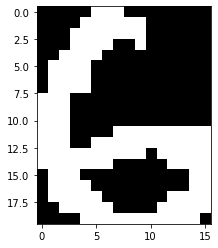

In [173]:
plt.imshow(data[39*6].reshape(20,16), cmap='Greys_r')

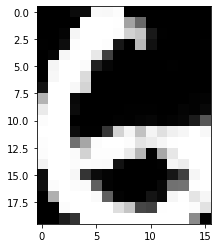

In [177]:
plt.imshow(rbm.reconstruct(data[39*6].T)[0].reshape(20,16), cmap='Greys_r')

In [175]:
generated_images = rbm.generate_image(iter_gibbs=100, number_image=100)

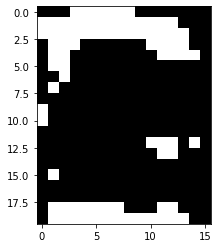

In [194]:
plt.imshow(generated_images[55].reshape(20,16), cmap='Greys_r')